### NCF 노션 정리:
https://www.notion.so/NCF-Neural-Collaborative-Filtering-6c40b27081dc432bad62126d017db246

## 0. Define Hyperparameters & Setting




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import scipy.sparse as sp
from sklearn.utils import shuffle
import os

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()
from math import log 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters
model_path = './models/'
num_layers = 6 # num_layers for MLP
num_factor = 64
batch_size = 100
learning_rate = 0.005
dropout_rate = 0.1
num_epochs = 20

## 1. Load Data

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/[인턴]2020겨울학기_DSAIL/ml-100k/u.data'
ratings = pd.read_csv(path, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], dtype={0: np.int32, 1: np.int32})

In [ ]:
ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1] # 나머지를 train set
test_ratings = ratings[ratings['rank_latest'] == 1] # 가장 마지막에 평가한 pair을 test set

# drop columns that we no longer need
train_ratings = train_ratings[['user_id', 'item_id', 'rating']]
test_ratings = test_ratings[['user_id', 'item_id', 'rating']]

In [ ]:
train_ratings.loc[:, 'rating'] = 1 # implicit

In [ ]:
class Load_Dataset(Dataset):
  def __init__(self, ratings, all_item_id):
      self.users, self.items, self.labels = self.get_dataset(ratings, all_item_id)

  def __len__(self):
      return len(self.users)

  def __getitem__(self, idx):
      return self.users[idx], self.items[idx], self.labels[idx]

  def get_dataset(self, ratings, all_item_id):
      users, items, labels = [], [], []
      user_item_set = set(zip(ratings['user_id'], ratings['item_id']))

      num_negatives = 4
      # 0중에서 negative item 생성
      for u, i in user_item_set:
          # positive instance
          users.append(u)
          items.append(i)
          labels.append(1)
          # negative instance
          for _ in range(num_negatives):
              negative_item = np.random.choice(all_item_id)
              while (u, negative_item) in user_item_set:
                  negative_item = np.random.choice(all_item_id) #  interaction이 없는 pair일때까지 sampling
              users.append(u)
              items.append(negative_item)
              labels.append(0)

      return torch.tensor(users), torch.tensor(items), torch.tensor(labels)      

In [ ]:
all_item_id = ratings['item_id'].unique()
num_users = ratings['user_id'].max()+1
num_items = ratings['item_id'].max()+1
train_loader = DataLoader(Load_Dataset(ratings, all_item_id), batch_size=512, num_workers=4, shuffle=True)
test_loader = DataLoader(Load_Dataset(test_ratings, all_item_id), batch_size=100, shuffle=False, num_workers=4)

## 2. Define GMF, MPL, NCF

In [ ]:
class NeuMF(nn.Module):
  def __init__(self, num_user, num_item, num_layers, num_factor=20, model='NCF', dropout=0.1):
    super(NeuMF, self).__init__()
    self.dropout = dropout
    self.model = model # GMF, MLP, NCF
    #self.GMF_model = GMF_model
    #self.MLP_model = MLP_model
    # GMP Embedding Layer
    self.embed_user_GMF = nn.Embedding(num_user, num_factor)
    self.embed_item_GMF = nn.Embedding(num_item, num_factor)
    # MLP Embedding Layer
    MLP_size = num_factor * (2 ** (num_layers - 1))
    self.embed_user_MLP = nn.Embedding(num_user, MLP_size)
    self.embed_item_MLP = nn.Embedding(num_item, MLP_size)

    # MLP Layers
    MLP_modules = []
    for i in range(num_layers):
      input_size = num_factor * (2 ** (num_layers - i))
      MLP_modules.append(nn.Dropout(p=self.dropout))
      MLP_modules.append(nn.Linear(input_size, input_size//2))
      MLP_modules.append(nn.ReLU())
    self.MLP_layers = nn.Sequential(*MLP_modules)

    # prediction_size (output FC layer의 input size)
    if self.model in ['MLP', 'GMF']:
      predict_size = num_factor
    else:
      predict_size = num_factor * 2
    
    # prediction_layer
    self.predict_layer = nn.Linear(predict_size, 1)
  
    # Output
    self.fc = nn.Linear(predict_size, 1)

  # weight initialization
  def _init_weight_(self):
    nn.init.normal_(self.embed_user_GMF.weight, std=0.01)
    nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
    nn.init.normal_(self.embed_item_GMF.weight, std=0.01)
    nn.init.normal_(self.embed_item_MLP.weight, std=0.01)

    for m in self.MLP_layers:
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
    nn.init.kaiming_uniform_(self.predict_layer.weight, 
                a=1, nonlinearity='sigmoid')

    for m in self.modules():
      if isinstance(m, nn.Linear) and m.bias is not None:
        m.bias.data.zero_()
     
  def forward(self, user, item):
    if not self.model == 'MLP':
      embed_user_GMF = self.embed_user_GMF(user)
      embed_item_GMF = self.embed_item_GMF(item)
      output_GMF = embed_user_GMF * embed_item_GMF
    if not self.model == 'GMF':
      embed_user_MLP = self.embed_user_MLP(user)
      embed_item_MLP = self.embed_item_MLP(item)
      interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
      output_MLP = self.MLP_layers(interaction)

    if self.model == 'GMF':
      output = output_GMF
    elif self.model == 'MLP':
      output = output_MLP
    else:
      output = torch.cat((output_GMF, output_MLP), -1)

    prediction = self.predict_layer(output)
    return prediction.view(-1)
model_name= 'NCF'
model = NeuMF(num_users, num_items, num_layers, num_factor=num_factor, model=model_name).to(device)

## 3. Define Loss function & optimizer

In [ ]:
criterion = nn.BCEWithLogitsLoss() # sigmoid필요x
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## 4. Define Evaluation Function

In [ ]:
# Metric1: HR
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0

# Metric2: NDCG
def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item) 
		return np.reciprocal(np.log2(index+2)) # 역수
	return 0

def metrics(model, test_loader, top_k=10): 
	HR, NDCG = [], []
	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(item, indices).to(device).detach().cpu().numpy().tolist()

		gt_item = item[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

## 5. Train Model & Evaluate

In [ ]:
count, best_hr = 0, 0
error = []
HR_list = []
NDCG_list = []
for epoch in range(num_epochs):
  print('------ Epoch [{}/{}] ------'.format(epoch+1, num_epochs))
  model.train() # train mode
  start = time.time()
  batch_loss = 0.0
  for i, (user, item, label) in enumerate(train_loader):
    user = user.to(device)
    item = item.to(device)
    label = label.float().to(device)

    model.zero_grad()
    prediction = model(user, item)
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    count += 1
  batch_loss += loss.item()
  error.append(np.mean(batch_loss))

  model.eval() # eval mode
  HR, NDCG = metrics(model, test_loader, top_k = 10)

  end = time.time()
  if i % 50 == 0 or (i+1)==len(train_loader):
    print('Step [{}/{}], Loss: {:.4f}'.format(i+1, len(train_loader), loss.item()))
  print("HR: {:.3f} \ tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))
  HR_list.append(np.mean(HR))
  NDCG_list.append(np.mean(NDCG))
  if HR > best_hr:
    best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
    if not os.path.exists(model_path):
      os.mkdir(model_path)
    torch.save(model, '{}{}.pth'.format(model_path, model_name))

print("End. Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(best_epoch, best_hr, best_ndcg))

------ Epoch [1/20] ------
Step [977/977], Loss: 0.2963
HR: 0.188 \ tNDCG: 0.107
------ Epoch [2/20] ------
Step [977/977], Loss: 0.3027
HR: 0.250 \ tNDCG: 0.147
------ Epoch [3/20] ------
Step [977/977], Loss: 0.2465
HR: 0.229 \ tNDCG: 0.114
------ Epoch [4/20] ------
Step [977/977], Loss: 0.2374
HR: 0.333 \ tNDCG: 0.138
------ Epoch [5/20] ------
Step [977/977], Loss: 0.2526
HR: 0.354 \ tNDCG: 0.141
------ Epoch [6/20] ------
Step [977/977], Loss: 0.2490
HR: 0.396 \ tNDCG: 0.160
------ Epoch [7/20] ------
Step [977/977], Loss: 0.2201
HR: 0.375 \ tNDCG: 0.152
------ Epoch [8/20] ------
Step [977/977], Loss: 0.1671
HR: 0.375 \ tNDCG: 0.151
------ Epoch [9/20] ------
Step [977/977], Loss: 0.1667
HR: 0.396 \ tNDCG: 0.174
------ Epoch [10/20] ------
Step [977/977], Loss: 0.1212
HR: 0.312 \ tNDCG: 0.120
------ Epoch [11/20] ------
Step [977/977], Loss: 0.1216
HR: 0.271 \ tNDCG: 0.107
------ Epoch [12/20] ------
Step [977/977], Loss: 0.1470
HR: 0.333 \ tNDCG: 0.135
------ Epoch [13/20] ----

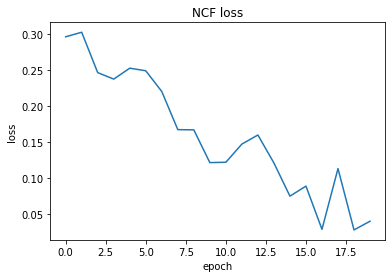

In [ ]:
plt.plot(error)
plt.title('NCF loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(best_epoch, best_hr, best_ndcg))

Best epoch 005: HR = 0.396, NDCG = 0.160


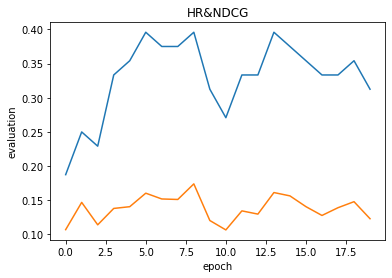

In [ ]:
plt.plot(HR_list)
plt.plot(NDCG_list)
plt.title('HR&NDCG')
plt.ylabel('evaluation')
plt.xlabel('epoch')
plt.show()